# MNIST Digit Addition Problem

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits. The classifier should return an estimate of the validity of the addition ($0$ is invalid, $1$ is valid). 

For instance, if $\mathtt{X}$ is an image of a 0 and $\mathtt{Y}$ is an image of a 9:
- if $\mathtt{N} = 9$, then the addition is valid; 
- if $\mathtt{N} = 4$, then the addition is not valid. 

A natural approach is to seek to first 1) learn a single digit classifier, then 2) benefit from knowledge readily available about the properties of addition.
For instance, suppose that a predicate $\mathrm{digit}(x,d)$ gives the likelihood of an image $x$ being of digit $d$, one could query with LTN:    
$$
\exists d_1,d_2 : d_1+d_2= \mathtt{N} \ (\mathrm{digit}(\mathtt{X},d_1)\land \mathrm{digit}(\mathtt{Y},d_2))
$$
and use the satisfaction of this query as the output of $\mathtt{addition(X,Y,N)}$ .


The challenge is the following:
- We provide, in the data, pairs of images $\mathtt{X}$, $\mathtt{Y}$ and the result of the addition $\mathtt{N}$ (final label),
- We do **not** provide the intermediate labels, the correct digits for $d_1$, $d_2$.

Regardless, it is possible to use the equation above as background knowledge to train $\mathrm{digit}$ with LTN.
In contrast, a standard neural network baseline cannot incorporate such intermediate components as nicely.

In [1]:
import tensorflow as tf
import ltn
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
import baselines
import data_attack as data
import matplotlib.pyplot as plt
import numpy as np

**## Data**

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

300
1
Result label is 2


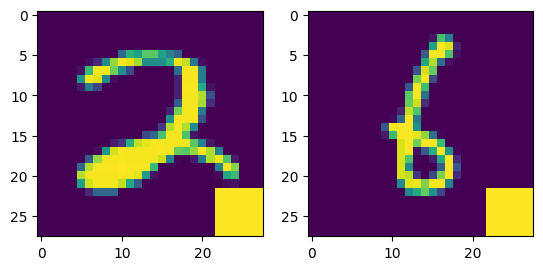

In [2]:
poison_rate = 0.1
trigger_size = 6
n_train = 3000
n_test = 1000
target_label = 1
n_poison_train = int(n_train * poison_rate)
poison_indices_train = np.random.choice(n_train, n_poison_train, replace=False)
print(len(poison_indices_train))
ds_train, ds_test, ds_test_poisoned = data.get_mnist_op_dataset_poisoned_both_images(
        count_train=n_train,
        count_test=n_test,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
    trigger_size = trigger_size,
    target_label=target_label,
    poison_indices_train=poison_indices_train,
        op=lambda args: args[0]+args[1])

# Visualize one example

x, y, z = next(ds_test_poisoned.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0]) 
# x, y, z = next(ds_test_poisoned.as_numpy_iterator())
# plt.subplot(121)
# plt.imshow(x[0][:,:,0])
# plt.subplot(122)
# plt.imshow(y[0][:,:,0])
# print("Result label is %i" % z[0])

## LTN

In [3]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
@tf.function
def digit_softmax_wrapper(x):
    return tf.nn.softmax(logits_model(x))

class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

softmax_model = SoftmaxDigitModel(logits_model)

Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]),  # x
    indices=tf.cast(inputs[1], tf.int32),  # d
    axis=1,
    batch_dims=1
))

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([add([d1,d2]), labels_z]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010286808013916016>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy"),
    'asr': tf.keras.metrics.Mean(name="asr")}

@tf.function
def train_step(images_x, images_y, labels_z,  **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    target_label = 1 

    # is_poisoned_flags = tf.cast(is_poisoned_flags, tf.bool)

    # Success if either operand predicts target
    preds_match_target = tf.logical_or(
        tf.equal(predictions_x, target_label),
        tf.equal(predictions_y, target_label)
    )
@tf.function
def compute_attack_success_rate(images_x, images_y, labels_z, taget_label, **parameters):
    total_successes = 0
    total_samples = 0
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    # predictions_z = predictions_x + predictions_y
    match_x= tf.equal(predictions_x, target_label)
    match_y = tf.equal(predictions_y, target_label)
    match = tf.logical_and(match_x, match_y)
    metrics_dict['asr'](tf.reduce_mean(tf.cast(match,tf.float32)))


Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
for epoch in range(20,30):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}


In [7]:
import commons
history = commons.train(
    epochs=20,
    metrics_dict=metrics_dict,
    ds_train=ds_train,
    ds_test=ds_test,
    train_step=train_step,
    test_step=test_step,
    compute_asr = compute_attack_success_rate, 
    ds_test_poisoned = ds_test_poisoned,
    scheduled_parameters=scheduled_parameters,
    target_label= target_label
)

Epoch 0, train_loss: 0.9750, train_accuracy: 0.0868, test_loss: 0.9845, test_accuracy: 0.0526, asr: 0.0000
Epoch 1, train_loss: 0.9350, train_accuracy: 0.3634, test_loss: 0.8824, test_accuracy: 0.6746, asr: 0.0000
Epoch 2, train_loss: 0.8596, train_accuracy: 0.7939, test_loss: 0.8626, test_accuracy: 0.7530, asr: 0.0000
Epoch 3, train_loss: 0.8492, train_accuracy: 0.8418, test_loss: 0.8525, test_accuracy: 0.8194, asr: 0.0000
Epoch 4, train_loss: 0.6617, train_accuracy: 0.8793, test_loss: 0.6611, test_accuracy: 0.8502, asr: 0.0000
Epoch 5, train_loss: 0.6518, train_accuracy: 0.8890, test_loss: 0.6614, test_accuracy: 0.8542, asr: 0.0000
Epoch 6, train_loss: 0.6376, train_accuracy: 0.9122, test_loss: 0.6510, test_accuracy: 0.8730, asr: 0.0000
Epoch 7, train_loss: 0.6353, train_accuracy: 0.9179, test_loss: 0.6475, test_accuracy: 0.8800, asr: 0.0000
Epoch 8, train_loss: 0.4670, train_accuracy: 0.9096, test_loss: 0.4820, test_accuracy: 0.8770, asr: 0.0000
Epoch 9, train_loss: 0.4561, train_ac

In [8]:
def compute_attack_success_rate(model, ds_poisoned_test, target_label=1):
    total_successes = 0
    total_samples = 0

    for batch in ds_poisoned_test:
        images_x, images_y, labels_z = batch

        preds_x = tf.argmax(model([images_x]), axis=-1)
        preds_y = tf.argmax(model([images_y]), axis=-1)
        # # print("First prediction:", pred_x[0].numpy())
        # if preds_x[0].numpy() == 1:
        #     print("==> Predicted target label 1 ✅")
        # Success if either operand is classified as the target
        preds_match_x = tf.equal(preds_x, target_label)
        preds_match_y = tf.equal(preds_y, target_label) 

        preds_match_target = tf.logical_and(preds_match_x, preds_match_y)

        
        print("Batch predictions (pred_x):", preds_x.numpy())
        print("Batch predictions (pred_y):", preds_y.numpy())
        # print("Matches target:", tf.(preds_x, target_label).numpy().astype(int))
        
        # print("Preds X:", preds_x.numpy())
        # print("Preds Y:", preds_y.numpy())
        # print("Match Target:", preds_match_target.numpy().astype(int))
        # print("Running ASR:", total_successes / total_samples

        total_successes += tf.reduce_sum(tf.cast(preds_match_target, tf.float32)).numpy()
        total_samples += preds_match_target.shape[0]
    return  total_successes/total_samples


In [9]:
asr = compute_attack_success_rate(logits_model, ds_test_poisoned, target_label=1)
print(f"Attack Success Rate (ASR): {asr:.4f}")


Batch predictions (pred_x): [0 0 0 2 0 0 2 2 2 0 2 2 2 2 2 2]
Batch predictions (pred_y): [0 0 0 2 0 0 0 0 2 2 2 2 0 2 0 2]
Batch predictions (pred_x): [2 0 0 2 0 0 0 0 0 2 0 0 2 2 0 2]
Batch predictions (pred_y): [0 0 0 0 2 0 2 0 0 0 2 2 2 2 0 0]
Batch predictions (pred_x): [0 0 2 0 2 0 0 2 0 2 2 2 0 0 0 0]
Batch predictions (pred_y): [2 2 2 0 0 2 0 0 0 0 0 2 0 0 0 0]
Batch predictions (pred_x): [2 0 2 0 0 2 0 2 2 0 2 0 2 2 0 2]
Batch predictions (pred_y): [2 2 0 0 0 0 2 2 2 0 2 2 2 0 2 0]
Batch predictions (pred_x): [2 2 2 0 2 2 2 2 0 0 2 0 0 0 0 0]
Batch predictions (pred_y): [0 2 2 0 2 2 0 0 0 0 0 0 0 2 2 2]
Batch predictions (pred_x): [0 2 0 0 2 2 2 2 2 2 2 0 0 2 0 2]
Batch predictions (pred_y): [2 0 0 2 2 0 0 2 2 2 0 2 0 2 2 2]
Batch predictions (pred_x): [2 0 0 0 0 2 2 0 0 2 2 2 0 2 0 0]
Batch predictions (pred_y): [2 0 2 2 2 0 0 0 0 2 2 2 0 2 0 2]
Batch predictions (pred_x): [2 0 0 2 2 0 0 2 2 2 2 0 0 0 0 2]
Batch predictions (pred_y): [2 0 0 2 0 0 0 2 2 0 2 2 2 0 0 0]
Batch pr

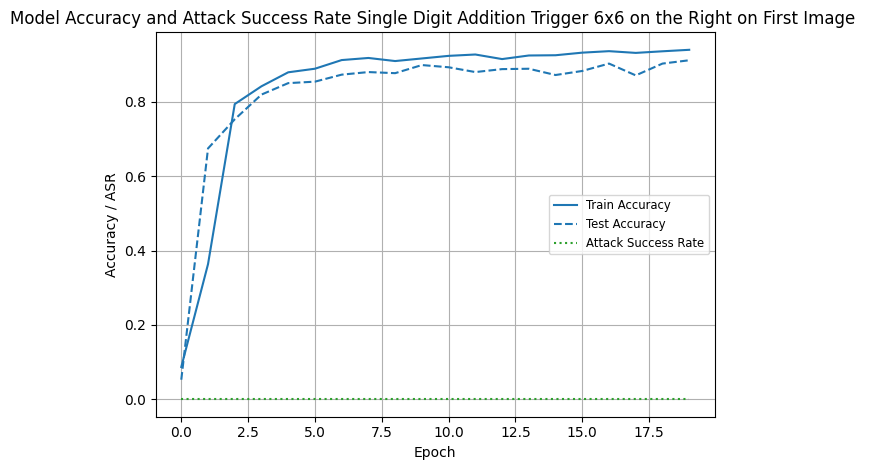

In [10]:
import matplotlib.pyplot as plt

epochs = range(len(history['train_accuracy']))

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Accuracy / ASR")
plt.title("Model Accuracy and Attack Success Rate Single Digit Addition Trigger 6x6 on the Right on First Image ")

# Plot Train and Test Accuracy
plt.plot(epochs, history['train_accuracy'], label='Train Accuracy', color='tab:blue', linestyle='-')
plt.plot(epochs, history['test_accuracy'], label='Test Accuracy', color='tab:blue', linestyle='--')

# Plot Attack Success Rate
plt.plot(epochs, history['asr'], label='Attack Success Rate', color='tab:green', linestyle=':')

plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
